# Examen práctico Tema 3
> Pablo Olivares Martínez

Primero importamos las librerías:

In [15]:
import sympy as sp
import numpy as np
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt

Para la realización del ejercicio se nos pide resolver el PVI $y'(t) = \frac{t-y(t)}{2}$ para $t \in [0,1]$ y $y(0)=1$ utilizando los métodos del punto medio, Heun y Runge-Kutta de orden 2 para finalmente compararlos con la solución exacta. Entonces primero vamos a definir la función y obtener su solución exacta:

In [4]:
a, b = 0, 1
ya = 1
eulerExpl, eulerImpl, eulerImplAprox = [], [], []
t, y0, z = sp.symbols('t, y_0,  z')

def f(t,z):
    return (t-z)/float(2)

In [6]:
# Definimos y como una función simbólica
y = sp.Function('y')
# Declaramos la EDO
edo = y(t).diff(t)-f(t,y(t))
# La igualamos a 0
sp.Eq(edo,0)
# Resolvemos simbólicamente la EDO
edo_sol = sp.dsolve(edo)
# Imponemos las condiciones iniciales
ics = {y(0): y0}
# De esta manera haríamos la sustituciones correspondientes
edo_sol.rhs.subs(t, 0),edo_sol.lhs.subs(t, 0).subs(ics)
# Ecuación asociada al PVI
CI_eq = sp.Eq(edo_sol.lhs.subs(t, 0).subs(ics),edo_sol.rhs.subs(t, 0))
# Solución del PVI
CI_sol = sp.solve(CI_eq)
# Única solución exacta de nuestro PVI 
sol_exacta = edo_sol.rhs.subs(CI_sol[0]).subs({y0:ya})

Ahora almacenaremos las soluciones exactas en un array para posteriores comparaciones:

In [7]:
y_x = sp.lambdify(t, sol_exacta, 'numpy')
xx = np.linspace(a,b,100)

Una vez hecho esto, comenzaré implementando el método del punto medio y de Heun. Para ello, definiré una función para cada una de ellas:

In [8]:
def integrateEulerMejorado(F,x0,y0,xfinal,N):    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N; h2 = h/2
    for n in range(N):
        Y.append(Y[n] + h*F(X[n]+h2,Y[n]+h2*F(X[n],Y[n])))
    return np.array(X),np.array(Y)

In [9]:
def integrateHeun(F,x0,y0,xfinal,N):    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N; h2 = h/2
    for n in range(N):
        Y.append(Y[n] + h2*(F(X[n],Y[n]) + F(X[n+1],Y[n]+h*F(X[n],Y[n]))))
    return np.array(X),np.array(Y)

Como nos pide que lo calculemos con $h=0'1$ y he definido la función según $N$ que es el número de iteraciones que queremos, haré un sencillo cálculo para conseguir dicho $h$ a partir de $N$. Como el intervalo es el $[0,1]$, necesitaremos $N  = \frac{1-0}{h} = 10$ iteraciones. Hecho esto, realicemos los cálculos:

In [25]:
N = 10
errorEulerMejorado, errorEulerHeun = ['Error max Euler mejorado'], ['Error max Euler-Heun']

eulerMejorado = {'xx': integrateEulerMejorado(f,a,ya,b,N)[0], 'yy': integrateEulerMejorado(f,a,ya,b,N)[1]}
eulerHeun = {'xx': integrateHeun(f,a,ya,b,N)[0], 'yy': integrateHeun(f,a,ya,b,N)[1]}
errorEulerMejorado.append(max(abs(eulerMejorado['yy']-y_x(eulerMejorado['xx']))))
errorEulerHeun.append(max(abs(eulerHeun['yy']-y_x(eulerHeun['xx']))))

Ahora imprimiremos los resultados:

In [17]:
print(tabulate([errorEulerMejorado, errorEulerHeun]))
eulerMejorado, eulerHeun

--------------------  -----------
Error Euler mejorado  0.000393624
Error Euler-Heun      0.000393624
--------------------  -----------


({'xx': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
  'yy': array([1.        , 0.95375   , 0.91462969, 0.88229149, 0.85640478,
         0.83665505, 0.82274311, 0.81438439, 0.81130815, 0.81325688,
         0.8199856 ])},
 {'xx': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
  'yy': array([1.        , 0.95375   , 0.91462969, 0.88229149, 0.85640478,
         0.83665505, 0.82274311, 0.81438439, 0.81130815, 0.81325688,
         0.8199856 ])})

Veamos también una comparación visual:

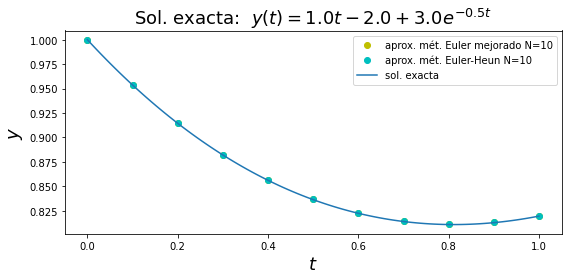

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(eulerMejorado['xx'],eulerMejorado['yy'], 'yo',label = "aprox. mét. Euler mejorado N={}".format(N))
ax.plot(eulerHeun['xx'],eulerHeun['yy'], 'co',label = "aprox. mét. Euler-Heun N={}".format(N))
ax.plot(xx, y_x(xx), label="sol. exacta")
ax.set_title(r"Sol. exacta:  $y(t)=%s$" % sp.latex(sol_exacta), fontsize=18)
ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
ax.legend()
fig.tight_layout()

Como podemos observar, estos dos métodos ofrecen el mismo resultado para todos los valores.

Ahora vamos a implementar el método de Runge-Kutta de orden 2 solicitado en el examen:

In [24]:
def integrateRK2(F,x0,y0,xfinal,N):
    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    for n in range(N):
        Y.append(Y[n] + (h/4)*(F(X[n],Y[n]) + 3*F(X[n] + (2/3)*h,Y[n]+(2/3)*h*F(X[n],Y[n]))))
    return np.array(X),np.array(Y)

Comparémoslo con los anteriores resultados:

In [29]:
errorRK2 = ['Error max RK2']
RK2 = {'xx': integrateRK2(f,a,ya,b,N)[0], 'yy': integrateRK2(f,a,ya,b,N)[1]}
errorRK2.append(max(abs(RK2['yy']-y_x(RK2['xx']))))
print(tabulate([errorEulerMejorado, errorEulerHeun,errorRK2]))
RK2

------------------------  -----------
Error max Euler mejorado  0.000393624
Error max Euler-Heun      0.000393624
Error max RK2             0.000393624
------------------------  -----------


{'xx': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'yy': array([1.        , 0.95375   , 0.91462969, 0.88229149, 0.85640478,
        0.83665505, 0.82274311, 0.81438439, 0.81130815, 0.81325688,
        0.8199856 ])}

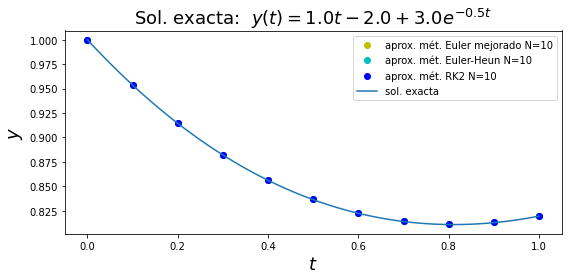

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(eulerMejorado['xx'],eulerMejorado['yy'], 'yo',label = "aprox. mét. Euler mejorado N={}".format(N))
ax.plot(eulerHeun['xx'],eulerHeun['yy'], 'co',label = "aprox. mét. Euler-Heun N={}".format(N))
ax.plot(RK2['xx'],RK2['yy'], 'bo',label = "aprox. mét. RK2 N={}".format(N))
ax.plot(xx, y_x(xx), label="sol. exacta")
ax.set_title(r"Sol. exacta:  $y(t)=%s$" % sp.latex(sol_exacta), fontsize=18)
ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
ax.legend()
fig.tight_layout()

Como podemos ver, no es sólo que el error máximo sea el mismo, sino que las tres funciones se comportan igual. Esto se debe a que los tres métodos son de orden 2, por lo que los errores serán del mismo orden e incluso ser los mismos.

In [30]:
%%timeit
integrateRK2(f,a,ya,b,N)

78.2 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
%%timeit
integrateEulerMejorado(f,a,ya,b,N)

65.4 µs ± 619 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [32]:
%%timeit
integrateHeun(f,a,ya,b,N)

69.4 µs ± 638 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Dado que los tres dan resultados idénticos, la única forma restante para compararlos es mediante coste computacional. como podemos ver, el coste computacional de los métodos es similar, siendo un poco peor el de Runge-Kutta de orden 2 y un poco más rápido el de Euler mejorado.